
=================== REGRESIÓN ===================

                            OLS Regression Results                            
Dep. Variable:              USD_VENTA   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     497.4
Date:                Fri, 30 May 2025   Prob (F-statistic):           3.87e-59
Time:                        01:43:17   Log-Likelihood:                -621.29
No. Observations:                 102   AIC:                             1251.
Df Residuals:                      98   BIC:                             1261.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


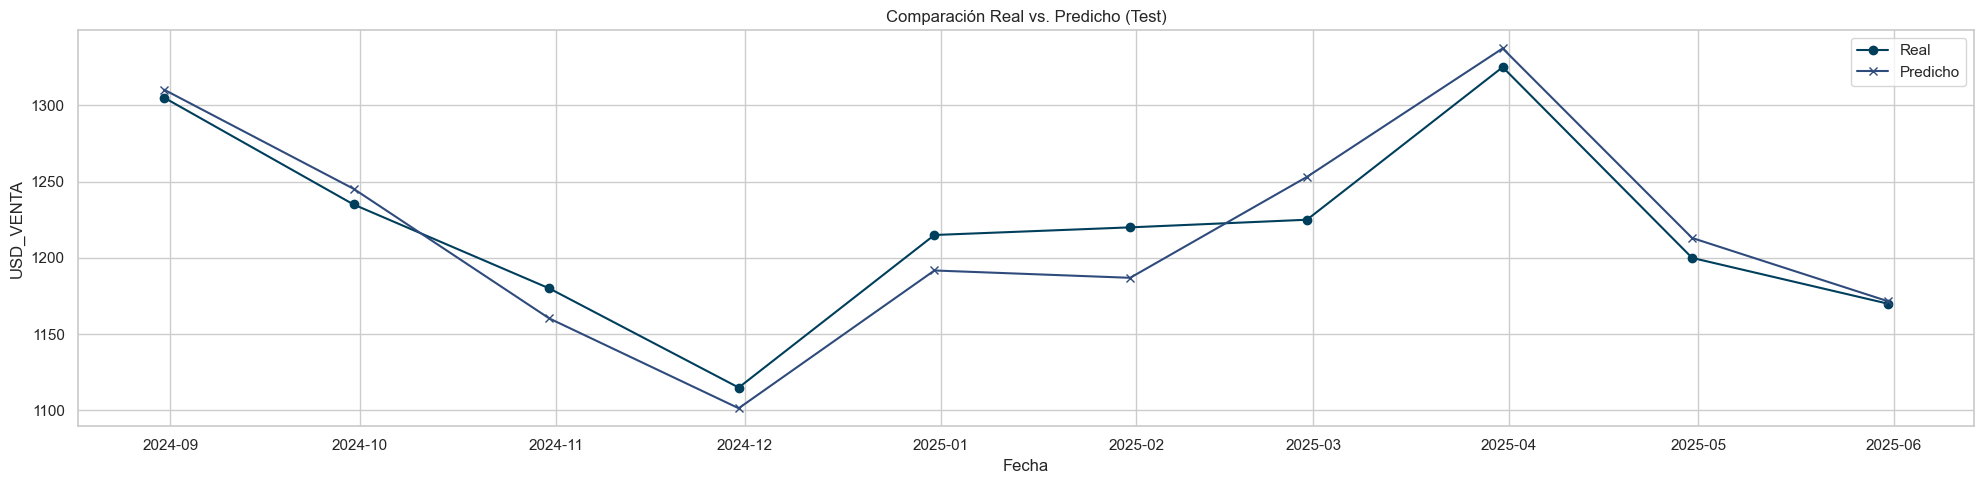


=================== TABLA DE ERRORES MAE Y RMSE ===================

   test_size  train_size         MAE        RMSE
0       0.10        0.90   17.841676   20.324973
1       0.15        0.85   16.009586   18.575007
2       0.20        0.80   49.320041   53.930067
3       0.25        0.75   39.069602   43.160359
4       0.30        0.70  146.106402  153.374166
5       0.35        0.65   53.313073   58.969161
6       0.40        0.60   47.714092   55.104188
7       0.45        0.55   32.722560   42.644510
8       0.50        0.50   38.262222   49.643016
9       0.55        0.45   70.395220   83.052717

=================== GRÁFICO DE ERRORES MAE Y RMSE ===================



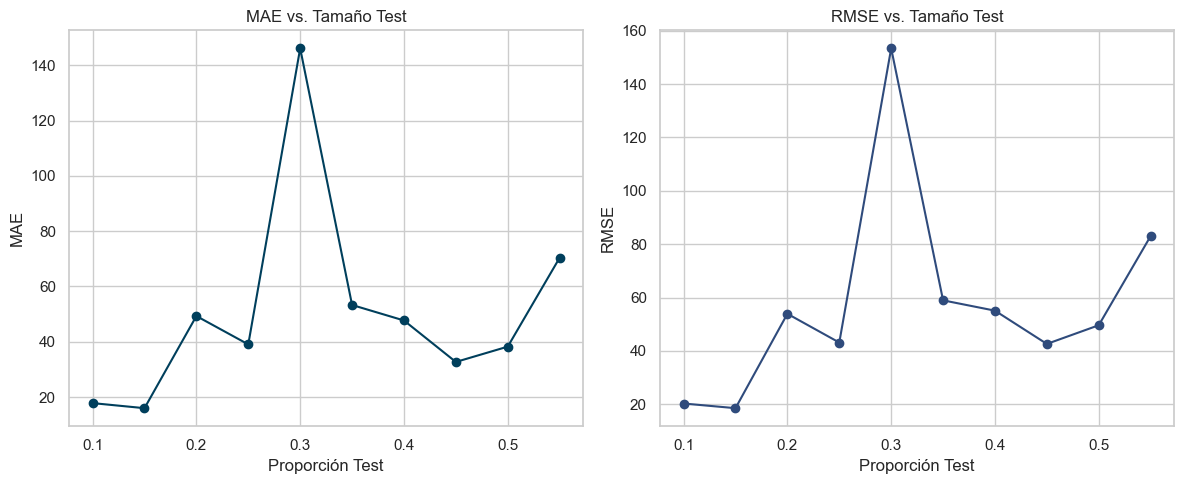


=================== PREDICCIÓN CORTO PLAZO ===================

          Mes  USD_Predicho_CP  IC_Bajo_CP  IC_Alto_CP  Delta_CP Tendencia_CP
0  2025-05-30          1170.00         NaN         NaN      0.00     🔴 Actual
1  2025-06-30          1130.85     1121.44     1140.25    -39.15       📉 Baja
2  2025-07-30          1113.43     1104.19     1122.66    -17.42       📉 Baja


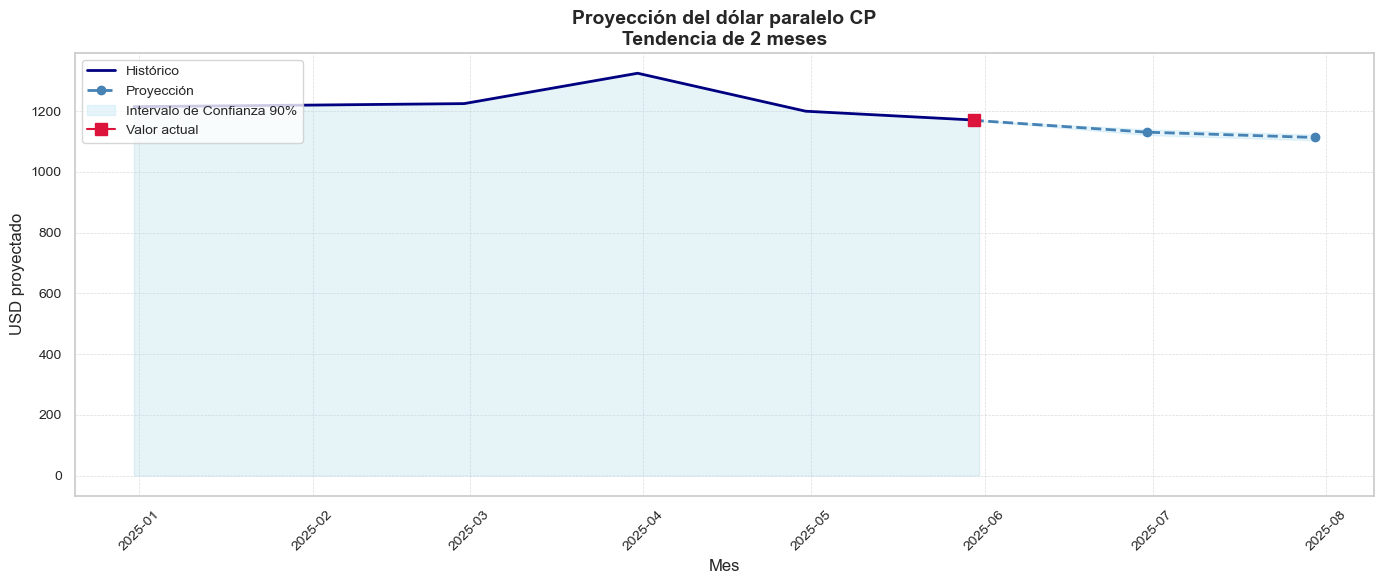


=================== PREDICCIÓN LARGO PLAZO ===================

           Mes  USD_Predicho_LP  IC_Bajo_LP  IC_Alto_LP  Delta_LP Tendencia_LP
0   2025-05-30          1170.00         NaN         NaN      0.00     🔴 Actual
1   2025-06-30          1134.04     1124.62     1143.47    -35.96       📉 Baja
2   2025-07-30          1119.64     1110.36     1128.91    -14.41       📉 Baja
3   2025-08-30          1105.41     1096.29     1114.53    -14.23       📉 Baja
4   2025-09-30          1091.36     1082.39     1100.34    -14.05       📉 Baja
5   2025-10-30          1077.50     1068.66     1086.33    -13.87       📉 Baja
6   2025-11-30          1063.80     1055.10     1072.50    -13.69       📉 Baja
7   2025-12-30          1050.28     1041.72     1058.85    -13.52       📉 Baja
8   2026-01-30          1036.94     1028.50     1045.37    -13.35       📉 Baja
9   2026-02-28          1023.76     1015.44     1032.07    -13.18       📉 Baja
10  2026-03-30          1010.74     1002.55     1018.94    -13.01 

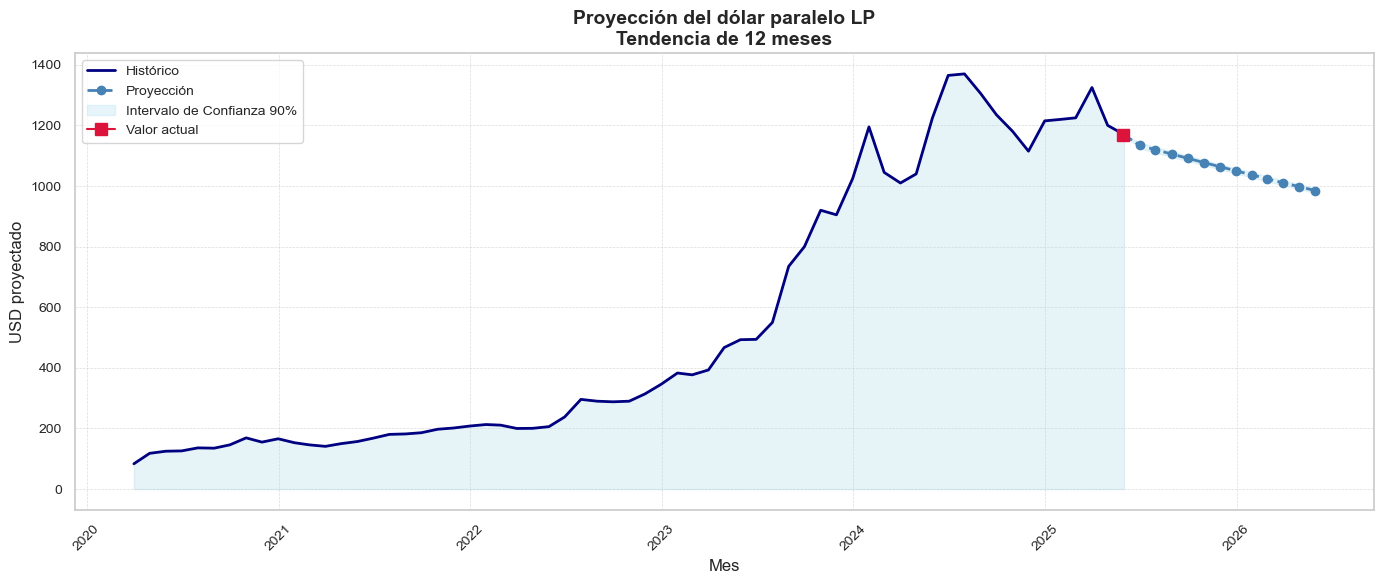


=================== GUARDADO ===================

Archivo guardado correctamente en: G:\Mi unidad\Prediccion USD Paralelo\prediccion_dolar.xlsx

=================== ÚLTIMOS VALORES DE VARIABLES ===================

IPC                2.00
RESERVAS          38.38
BADLAR            33.00
M2          21429356.00
RP               655.00
MEP             1164.80
Name: 2025-05-31 00:00:00, dtype: float64


In [92]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import datetime as dt
from dateutil.relativedelta import relativedelta
from openpyxl.utils import get_column_letter
from openpyxl import load_workbook
from openpyxl.styles import numbers
import matplotlib.dates as mdates
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
# Definir paleta financiera global
financial_palette = ['#003f5c', '#2f4b7c', '#2f7c5e', '#7bcf6f', '#555555']
# Aplicar paleta global con seaborn
sns.set_palette(financial_palette)
sns.set_style("whitegrid")  # estilo limpio y profesional
# cambiar el color por defecto en matplotlib:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=financial_palette)

sheet_id = "1gWaV7dbwImFO6NrfTO08QmZGZIdHBsOdyweaR3BJbYY"
sheet_name = "Datos%20Prediccion%20USD%20Blue"  # <- espacios reemplazados
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)
hoy = dt.date.today()
#  Parsear fechas
fechas = ['FECHA_USD', 'FECHA_IPC', 'FECHA_RP', 'FECHA_RESERVAS', 'FECHA_M2', 'FECHA_BADLAR', 'FECHA_TC', 'FECHA_MEP']
for col in fechas:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)
#  Función para corregir números mal formateados
def fix_number_format(s):
    if pd.isna(s):
        return s
    s = str(s)
    s = s.replace(',', '.')
    if s.count('.') > 1:
        parts = s.split('.')
        s = ''.join(parts[:-1]) + '.' + parts[-1]
    return s
#  Convertir strings a float
variables = ['USD_VENTA', 'IPC', 'RP', 'RESERVAS', 'M2', 'BADLAR', 'TC', 'MEP']
for col in variables:
    df[col] = df[col].apply(fix_number_format)
    df[col] = pd.to_numeric(df[col], errors='coerce')
#  Consolidar por mes con último valor del mes
def consolidar_mensual(fecha_col, valor_col):
    temp = df[[fecha_col, valor_col]].dropna()
    temp['MES'] = temp[fecha_col].dt.to_period('M')
    mensual = temp.sort_values(fecha_col).groupby('MES').last().reset_index()
    return mensual[['MES', valor_col]]
#  Consolidar cada serie
usd = consolidar_mensual('FECHA_USD', 'USD_VENTA')
ipc = consolidar_mensual('FECHA_IPC', 'IPC')
rp = consolidar_mensual('FECHA_RP', 'RP')
reservas = consolidar_mensual('FECHA_RESERVAS', 'RESERVAS')
m2 = consolidar_mensual('FECHA_M2', 'M2')
badlar = consolidar_mensual('FECHA_BADLAR', 'BADLAR')
tc = consolidar_mensual('FECHA_TC', 'TC')
mep = consolidar_mensual('FECHA_MEP', 'MEP')
#  Unir todos los DataFrames
dfs = [usd, ipc, rp, reservas, m2, badlar, tc, mep]
df_final = reduce(lambda left, right: pd.merge(left, right, on='MES', how='outer'), dfs)
#  Convertir MES a datetime (último día del mes)
df_final['MES'] = df_final['MES'].dt.to_timestamp(how='end').dt.normalize()
#  Ordenar por fecha
df_final = df_final.sort_values('MES').reset_index(drop=True)
#  Rellenar automáticamente los valores faltantes con los del mes anterior
df_final = df_final.fillna(method='ffill')
print("\n=================== REGRESIÓN ===================\n")
X = df_final[['IPC', 'RESERVAS', 'M2']].apply(pd.to_numeric, errors='coerce') # Sin RP y BADLAR por No Significancia. Sin TC y MEP por Multicolinealidad
y = pd.to_numeric(df_final['USD_VENTA'], errors='coerce')
data = pd.concat([y, X], axis=1).dropna()
y = data['USD_VENTA']
X = data.drop(columns=['USD_VENTA'])
X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()
print(modelo.summary())
print("\n=================== TESTS ===================\n")
# Heterocedasticidad
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]:.4f}")
# Autocorrelación
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson: {dw_stat:.2f}")
bg_test = acorr_breusch_godfrey(model, nlags=1)
print(f"Breusch-Godfrey p-value: {bg_test[1]:.4f}")
print("\n=================== VIF VARIABLES ===================\n")
variables = df_final[['IPC', 'RESERVAS', 'M2']].copy()
# Calcular VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
#  Convertir MES a datetime e indexar
df_final['MES'] = pd.to_datetime(df_final['MES'])
df_final = df_final.sort_values('MES').reset_index(drop=True)
df_final.set_index('MES', inplace=True)
#  Crear solo los lags necesarios
df_final['RESERVAS_lag1'] = df_final['RESERVAS'].shift(1)
df_final['BADLAR_lag1'] = df_final['BADLAR'].shift(1)
df_final['M2_lag1'] = df_final['M2'].shift(1)
#  Filtrar desde marzo 2020 (inicio MEP)
df_final = df_final[df_final.index >= '2020-03-01']
#  Eliminar NaNs por los lags
df_model = df_final.dropna()
#  Definir variables
y = df_model['USD_VENTA']
X = df_model[['IPC', 'RESERVAS_lag1', 'BADLAR_lag1', 'RP', 'MEP']]
X = sm.add_constant(X)
#  Train/Test Split (85% train)   AJUSTAR A MEJOR LEARN-TEST
train_size = int(len(df_model) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
#  Ajustar modelo
model = sm.OLS(y_train, X_train).fit()
#  Predicción
y_pred = model.predict(X_test)
#  Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\n=================== ERRORES ===================\n")
print(f'Error Absoluto Medio(MAE): {mae:.2f}')
print(f'Raíz del Error Cuadrático Medio(RMSE): {rmse:.2f}')
#  Predicción siguiente mes (junio)
ultimo_mes = df_model.index.max()  # mayo 2025, último mes real
last_row = df_model.loc[ultimo_mes]
next_input = pd.DataFrame({
    'const': [1],
    'IPC': [last_row['IPC']],
    'RESERVAS_lag1': [last_row['RESERVAS']],
    'BADLAR_lag1': [last_row['BADLAR']],
    'RP': [last_row['RP']],
    'MEP': [last_row['MEP']],
})
#  Gráfico
print("\n=================== GRAFICO PREDICCIÓN VS REALIZADO ===================\n")
plt.figure(figsize=(20,5))
plt.plot(y_test.index, y_test, label='Real', marker='o')
plt.plot(y_test.index, y_pred, label='Predicho', marker='x')
plt.title('Comparación Real vs. Predicho (Test)')
plt.xlabel('Fecha')
plt.ylabel('USD_VENTA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Lista de tamaños de test (fracciones del dataset)
print("\n=================== TABLA DE ERRORES MAE Y RMSE ===================\n")
test_sizes = np.arange(0.1, 0.6, 0.05)  # desde 10% hasta 55% test, paso 5%
results = []
for test_size in test_sizes:
    train_size = int(len(df_model) * (1 - test_size))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    results.append({
        'test_size': test_size,
        'train_size': 1 - test_size,
        'MAE': mae,
        'RMSE': rmse
    })
# Convertir a DataFrame para mejor visualización
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)
# Gráficos para visualizar
print("\n=================== GRÁFICO DE ERRORES MAE Y RMSE ===================\n")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(df_results['test_size'], df_results['MAE'], marker='o')
plt.title('MAE vs. Tamaño Test')
plt.xlabel('Proporción Test')
plt.ylabel('MAE')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(df_results['test_size'], df_results['RMSE'], marker='o', color='#2f4b7c')
plt.title('RMSE vs. Tamaño Test')
plt.xlabel('Proporción Test')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show() 

def tasa_crecimiento_mensual_serie(serie, meses=12):
    """
     Calcula tasa de crecimiento mensual promedio basada en los últimos 'meses' meses.
    """
    serie_reciente = serie[-meses:]
     #  Crecimiento relativo total
    crecimiento_total = serie_reciente.iloc[-1] / serie_reciente.iloc[0] - 1
    #  Tasa mensual promedio (asumiendo crecimiento compuesto)
    tasa_mensual = (1 + crecimiento_total) ** (1 / (meses - 1)) - 1
    return tasa_mensual
def proyectar_dolar_tendencia_real(model, df_final, meses=2, alpha=0.90, periodo_tendencia=2, sufijo="_CP"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import datetime as dt
    from dateutil.relativedelta import relativedelta
    import pandas as pd

    hoy = dt.date.today()
    fechas = [hoy + relativedelta(months=i) for i in range(1, meses + 1)]

    last_row = df_final.iloc[-1].copy()

    # Calcular tasas de crecimiento mensual
    tasas = {}
    for var in ['IPC', 'RESERVAS', 'BADLAR', 'RP', 'MEP']:
        tasas[var] = tasa_crecimiento_mensual_serie(df_final[var], meses=periodo_tendencia)

    actual_usd = last_row['USD_VENTA']
    predicciones = []

    for i in range(meses):
        for var in tasas:
            last_row[var] *= (1 + tasas[var])

        input_i = pd.DataFrame({
            'const': 1,
            'IPC': [last_row['IPC']],
            'RESERVAS_lag1': [last_row['RESERVAS']],
            'BADLAR_lag1': [last_row['BADLAR']],
            'RP': [last_row['RP']],
            'MEP': [last_row['MEP']],
        })

        pred_i = model.get_prediction(input_i)
        pred_val = pred_i.predicted_mean[0]
        conf_int = pred_i.conf_int(alpha=alpha)
        lower, upper = conf_int[0]

        predicciones.append({
            'Mes': fechas[i].strftime('%Y-%m-%d'),
            'USD_Predicho' + sufijo: pred_val,
            'IC_Bajo' + sufijo: lower,
            'IC_Alto' + sufijo: upper,
            'Delta' + sufijo: pred_val - actual_usd,
            'Tendencia' + sufijo: '📈 Sube' if lower > actual_usd else ('📉 Baja' if upper < actual_usd else '⏸️ Incierto')
        })

        last_row['USD_VENTA'] = pred_val
        actual_usd = pred_val

    df_pred = pd.DataFrame(predicciones)

    df_actual = pd.DataFrame([{
        'Mes': hoy.strftime('%Y-%m-%d'),
        'USD_Predicho' + sufijo: df_final['USD_VENTA'].iloc[-1],
        'IC_Bajo' + sufijo: None,
        'IC_Alto' + sufijo: None,
        'Delta' + sufijo: 0,
        'Tendencia' + sufijo: '🔴 Actual'
    }])

    df_pred = pd.concat([df_actual, df_pred], ignore_index=True)

    # Redondear valores
    columnas_redondear = [col for col in df_pred.columns if col.startswith('USD_Predicho') or col.startswith('IC_') or col.startswith('Delta')]
    df_pred[columnas_redondear] = df_pred[columnas_redondear].round(2)

    # Mostrar tabla
    print(df_pred)

    # Función de gráfico
    def graficar_proyeccion(df_pred, df_final, sufijo, periodo_tendencia):
        sns.set(style='whitegrid')
        plt.figure(figsize=(14, 6))

        # Formato de fechas
        df_final = df_final.copy()
        df_final['Mes'] = pd.to_datetime(df_final['Fecha']) if 'Fecha' in df_final else pd.to_datetime(df_final.index)

        # Filtrar histórico
        if sufijo == "_CP":
            df_hist = df_final.tail(6)
        elif sufijo == "_LP":
            df_hist = df_final
        else:
            df_hist = df_final.tail(6)

        # Asegurar que Mes esté en datetime también en predicciones
        df_pred['Mes'] = pd.to_datetime(df_pred['Mes'])

        # Línea histórica
        plt.plot(df_hist['Mes'], df_hist['USD_VENTA'], label='Histórico',
                 color='navy', linewidth=2)
        plt.fill_between(df_hist['Mes'], df_hist['USD_VENTA'],
                         color='lightblue', alpha=0.3)

        # Proyección
        plt.plot(df_pred['Mes'], df_pred['USD_Predicho' + sufijo],
                 label='Proyección', linestyle='--', marker='o',
                 color='steelblue', linewidth=2)

        # Banda de confianza
        ic_bajo_ext = [df_hist['USD_VENTA'].iloc[-1]] + df_pred['IC_Bajo' + sufijo][1:].tolist()
        ic_alto_ext = [df_hist['USD_VENTA'].iloc[-1]] + df_pred['IC_Alto' + sufijo][1:].tolist()
        plt.fill_between(df_pred['Mes'], ic_bajo_ext, ic_alto_ext,
                         color='skyblue', alpha=0.2, label='Intervalo de Confianza 90%')

        # Punto actual
        plt.plot(df_pred['Mes'].iloc[0], df_hist['USD_VENTA'].iloc[-1],
                 marker='s', color='crimson', markersize=8, label='Valor actual')

        # Título y estilo
        plt.title(f'Proyección del dólar paralelo{sufijo.replace("_", " ")}\nTendencia de {periodo_tendencia} meses',
                  fontsize=14, weight='bold')
        plt.xlabel('Mes', fontsize=12)
        plt.ylabel('USD proyectado', fontsize=12)
        plt.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Ejecutar gráfico
    graficar_proyeccion(df_pred, df_final, sufijo, periodo_tendencia)

    return df_pred

# Corto plazo
print("\n=================== PREDICCIÓN CORTO PLAZO ===================\n")
predicciones_CP = proyectar_dolar_tendencia_real(model, df_final, meses=2, periodo_tendencia=2, sufijo="_CP")
# Largo plazo
print("\n=================== PREDICCIÓN LARGO PLAZO ===================\n")
predicciones_LP = proyectar_dolar_tendencia_real(model, df_final, meses=12, periodo_tendencia=12, sufijo="_LP")

# Crear df_comparacion
df_comparacion = pd.DataFrame({
    'Fecha': y_test.index,
    'USD_Real': y_test.values,
    'USD_Predicho': y_pred.values,
    'Error_Abs': abs(y_test.values - y_pred.values)
})
# Ruta de salida
ruta_salida = r'G:\Mi unidad\Prediccion USD Paralelo\prediccion_dolar.xlsx'
# Guardar en Excel
with pd.ExcelWriter(ruta_salida, engine='openpyxl') as writer:
    df_final.reset_index().to_excel(writer, sheet_name='Datos Originales', index=False)
    predicciones_CP.to_excel(writer, sheet_name='Prediccion_CP', index=False)
    predicciones_LP.to_excel(writer, sheet_name='Prediccion_LP', index=False)
    df_comparacion.to_excel(writer, sheet_name='Real vs Predicho', index=False)
# Abrir libro y ajustar columnas
libro = load_workbook(ruta_salida)
for hoja in libro.sheetnames:
    hoja_activa = libro[hoja]
    for col in hoja_activa.columns:
        max_largo = max(len(str(cell.value)) if cell.value is not None else 0 for cell in col)
        col_letra = get_column_letter(col[0].column)
        hoja_activa.column_dimensions[col_letra].width = max_largo + 5
        # Aplicar formato de fecha si la primera fila tiene 'Fecha'
        if col[0].value == 'Fecha':
            for cell in col[1:]:
                if isinstance(cell.value, (pd.Timestamp, pd._libs.tslibs.timestamps.Timestamp)):
                    cell.number_format = 'DD/MM/YYYY'
# Guardar archivo
libro.save(ruta_salida)
print("\n=================== GUARDADO ===================\n")
print("Archivo guardado correctamente en:", ruta_salida)
print("\n=================== ÚLTIMOS VALORES DE VARIABLES ===================\n")
print(last_row[['IPC', 'RESERVAS', 'BADLAR', 'M2', 'RP', 'MEP']])  # REVISAR ULTIMOS DATOS CORRECTOS